In this exercise you are asked to implement a simple genotyper based on
the GATK naive Bayesian method explained in the lecture slides. The
method is also explained here: https://gatk.broadinstitute.org/hc/
en-us/articles/360035890511-Assigning-per-sample-genotypes-HaplotypeCalle

Your implementation is used to analyse a pseudo-pileup file input.txt to
infer the most probable genotype for the given genomic loci. Each row in
the file input.txt contains the following information: chromosome, 1-based
genomic coordinate, reference base, the number of reads covering the site,
read bases and base qualities. The column containing base qualities contain
the actual Phred quality scores (instead of an ASCII character encoding),
which measure sequencing error. Phred score q is given by q = −10 log10 e,
where e is the probability that the corresponding base call is incorrect.
The data in the columns ”read bases” and ”base qualities” are commadelimited and each read base-base quality pair is obtained from one sequencing read (from the “pileup”). Your genotyper should compute P(G|D) of
all 10 genotypes {”GG”, ”GC”, ”GA”, ”GT”, ”CC”, ”CA”, ”CT”, ”AA”,
”AT”, ”TT”} where D is the data, i.e the information in the columns ”read
bases” and ”base qualities” and G denotes a genotype. The genotyper should
determine the maximum a posteriori (MAP) estimate of the genotype.


In [103]:
col_names <- c("Chromosome", "Coordinate", "RefBase", "NumReads", "ReadBases", "BaseQualities")
data <- read.table("input.txt", header = FALSE, sep = "\t", col.names = col_names, stringsAsFactors = FALSE)

# Process ReadBases and BaseQualities columns
data$ReadBases <- strsplit(as.character(data$ReadBases), split=",")
data$BaseQualities <- strsplit(as.character(data$BaseQualities), split=",")

head(data)  

,Chromosome,Coordinate,RefBase,NumReads,ReadBases,BaseQualities
,<int>,<int>,<chr>,<int>,<list>,<list>
1,20,4369726,G,113,"G, G, G, G, G, G, G, G, G, G, C, G, G, G, G, G, G, G, C, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G, G","27, 32, 33, 34, 31, 32, 34, 33, 30, 34, 31, 33, 32, 33, 33, 33, 33, 30, 31, 29, 32, 33, 29, 33, 33, 33, 33, 32, 32, 34, 33, 33, 34, 32, 33, 34, 32, 33, 33, 33, 33, 33, 29, 32, 32, 33, 31, 33, 33, 33, 32, 32, 33, 33, 33, 32, 30, 33, 31, 33, 33, 33, 33, 33, 34, 34, 31, 32, 32, 32, 32, 32, 32, 32, 33, 33, 31, 31, 32, 32, 31, 33, 33, 32, 31, 31, 31, 32, 33, 33, 33, 31, 33, 31, 31, 33, 31, 33, 31, 29, 32, 32, 32, 33, 32, 33, 33, 31, 32, 28, 32, 31, 31"
2,20,4369728,T,113,"T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, G, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T","33, 31, 31, 30, 31, 31, 30, 31, 32, 31, 30, 27, 31, 30, 31, 30, 29, 31, 29, 30, 32, 29, 31, 31, 32, 32, 29, 30, 31, 31, 32, 31, 32, 31, 31, 29, 32, 31, 32, 29, 32, 29, 32, 32, 32, 29, 32, 31, 32, 32, 31, 32, 32, 32, 30, 31, 32, 25, 32, 28, 32, 32, 32, 32, 32, 29, 30, 28, 30, 30, 32, 30, 31, 31, 32, 30, 30, 30, 30, 30, 31, 32, 30, 30, 30, 30, 31, 32, 32, 32, 30, 31, 30, 30, 32, 28, 32, 30, 30, 31, 30, 31, 31, 31, 26, 32, 32, 27, 25, 31, 30, 30, 29"
3,20,4369731,A,113,"A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, G, A, A, A, A, A","32, 34, 33, 32, 32, 32, 32, 33, 33, 32, 31, 34, 30, 34, 34, 30, 32, 31, 32, 33, 30, 33, 34, 34, 33, 31, 31, 31, 32, 33, 33, 33, 33, 31, 31, 31, 33, 33, 33, 33, 30, 33, 33, 33, 30, 33, 33, 33, 33, 33, 33, 33, 33, 32, 32, 33, 27, 33, 32, 33, 33, 33, 33, 33, 31, 32, 31, 32, 32, 33, 29, 33, 33, 33, 32, 32, 32, 33, 30, 33, 33, 29, 32, 32, 32, 32, 33, 33, 33, 32, 27, 32, 32, 33, 32, 33, 32, 30, 33, 32, 33, 33, 32, 33, 33, 33, 33, 25, 33, 32, 32, 32, 31"
4,20,4369733,T,110,"T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, C, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T, T","33, 33, 32, 33, 33, 29, 33, 29, 27, 30, 33, 29, 32, 33, 33, 32, 33, 29, 33, 31, 33, 33, 32, 28, 32, 32, 33, 32, 33, 33, 33, 28, 32, 32, 32, 32, 33, 21, 32, 33, 33, 31, 33, 32, 32, 32, 33, 33, 32, 33, 32, 29, 33, 30, 32, 25, 33, 32, 33, 32, 32, 28, 31, 32, 31, 31, 33, 33, 32, 18, 32, 31, 31, 31, 33, 31, 32, 33, 31, 31, 30, 31, 33, 33, 32, 33, 31, 31, 31, 31, 32, 31, 32, 31, 31, 32, 31, 32, 31, 33, 30, 32, 33, 32, 31, 32, 31, 31, 32, 31"
5,20,4369734,C,111,"C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, G, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C","32, 32, 32, 30, 26, 31, 33, 33, 27, 29, 33, 31, 33, 33, 33, 29, 32, 33, 30, 33, 33, 33, 32, 31, 30, 33, 31, 32, 33, 32, 33, 32, 30, 31, 33, 32, 33, 32, 32, 32, 32, 32, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31, 32, 30, 32, 30, 32, 32, 32, 32, 32, 31, 31, 32, 31, 31, 32, 31, 32, 32, 32, 31, 31, 31, 32, 31, 32, 32, 

In [1]:
data <- read.table("input.txt", header = FALSE, sep = "\t")

In [2]:
compute_p <- function(bases, quals, priors, genotypes) {
    posteriors <- numeric(length(genotypes))
    for (g in 1:length(genotypes)) {
        genotype <- unlist(strsplit(genotypes[g], "")) # decompose the genotype into its two alleles as G = (A1, A2)
        likelihood <- 1 
        for (i in 1:length(bases)) {
            base <- bases[i]
            qual <- as.numeric(quals[i])
            error_prob <- 10^(-qual/10) 
            
            # Calculate probability of observing the base read given the genotype
            # Homozygous genotype
            if (length(unique(genotype)) == 1) { 
                if (base %in% genotype) {
                    likelihood <- likelihood * (1 - error_prob)
                } else {
                    likelihood <- likelihood * error_prob/3
                }
            # Heterozygous genotype
            } else {          
                allele1_prob <- ifelse(base == genotype[1], 1 - error_prob, error_prob) / 2
                allele2_prob <- ifelse(base == genotype[2], 1 - error_prob, error_prob) / 2
                likelihood <- likelihood * (allele1_prob + allele2_prob)
            }
        }
        posterior <- likelihood * priors[g]
        posteriors[g] <- posterior
    }
    return(posteriors/ sum(posteriors)) # Normalize to sum to 1
}


In the first part, assume that the prior probabilities of the genotypes have
uniform distribution for all sites. In your report, present a summary of the
selected genotypes. (3 points). 

In [3]:
genotypes <- c("GG", "GC", "GA", "GT", "CC", "CA", "CT", "AA", "AT", "TT")
uniform_priors <- rep(0.1, length(genotypes))  
selected_genotypes <- character(nrow(data)) 

for (i in 1:nrow(data)) {  
    bases <- unlist(strsplit(as.character(data[i, 5]), split=","))
    quals <- unlist(strsplit(as.character(data[i, 6]), split=","))
    ps <- compute_p(bases, quals, uniform_priors, genotypes) # Compute posterior for each genotype
    #cat(" ps: ", ps)
    selected_genotypes[i] <- genotypes[which.max(ps)] # select genotype from the list with max posterior
    #cat(" selected: ", selected_genotypes[i])
}

# Most probable genotypes
genotype_table <- table(selected_genotypes)
print(genotype_table)

selected_genotypes
 AA  AT  CA  CC  CT  GA  GC  GG  GT  TT 
124  11  16  68  33  34  25 146  11  92 


In the second part, repeat the analysis
for the selected DNA sites below, using the indicated population genotype
frequencies (ALL=whole population, EUR=european, FIN=finnish) as prior
probabilities. Compare the results from the different population frequencies
and with the results in part 1 (1.5 points).

In [4]:
##create 3-dimensional array of prior probabilities
genotypes=c("GG","GC", "GA", "GT", "CC", "CA", "CT","AA" , "AT", "TT")
priorList2<-array(0,c(10,4,5)) #genotypes x populations x genomic coordinates

priorList2[match(c("GG", "CC", "GC", "CT", "GT"), genotypes),1,1]<-c(0.308,0.294,0.385,0.011,0.003) # All 
priorList2[match(c("GG", "CC", "GC"), genotypes),2,1]<-c(0.239,0.237,0.525) # Eur
priorList2[match(c("GG", "CC", "GC"), genotypes),3,1]<-c(0.202,0.232,0.566) # Fin

priorList2[match(c("CC", "CT", "TT"), genotypes),1,2]<-c(0.849,0.146,0.005)
priorList2[match(c("CC", "CT", "TT"), genotypes),2,2]<-c(0.899,0.099,0.002)
priorList2[match(c("CC", "CT"), genotypes),3,2]<-c(0.909,0.091)

priorList2[match(c("TT", "AA", "AT"), genotypes),1,3]<-c(0.116,0.031,0.853) # 29812725 ALL
priorList2[match(c("TT", "AA", "AT"), genotypes),2,3]<-c(0.161,0.021,0.827)
priorList2[match(c("TT", "AA", "AT"), genotypes),3,3]<-c(0.131,0.010,0.859)

priorList2[match(c("CC", "GC", "GG"), genotypes),1,4]<-c(0.917,0.082,0.001)
priorList2[match(c("CC", "GC"), genotypes),2,4]<-c(0.913,0.087)
priorList2[match(c("CC", "GC"), genotypes),3,4]<-c(0.980,0.020)

priorList2[match(c("TT", "CC", "CT"), genotypes),1,5]<-c(0.919,0.005,0.075) # 29652851 ALL
priorList2[match(c("TT", "CC", "CT"), genotypes),2,5]<-c(0.799,0.010,0.191)
priorList2[match(c("TT", "CC", "CT"), genotypes),3,5]<-c(0.788,0.020,0.192)

uniform_prior <- 0.1
priorList2[, 4, ] <- array(uniform_prior, c(10, 1, 5))
priorList2[,4,4]

[1] 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1

In [5]:
col_names <- c("Chromosome", "Coordinate", "RefBase", "NumReads", "ReadBases", "BaseQualities")
data <- read.table("input.txt", header = FALSE, sep = "\t", col.names = col_names, stringsAsFactors = FALSE)
selected_coordinates <- as.numeric(c(29814971, 47131885, 29812725, 47132180, 29652851))

filtered_data <- data[data$Coordinate %in% selected_coordinates, ]
filtered_data <- filtered_data[order(match(filtered_data$Coordinate, selected_coordinates)),]
#filtered_data$ReadBases <- strsplit(as.character(filtered_data$ReadBases), split=",")  
#filtered_data$BaseQualities <- strsplit(as.character(filtered_data$BaseQualities), split=",")
filtered_data

,Chromosome,Coordinate,RefBase,NumReads,ReadBases,BaseQualities
,<int>,<int>,<chr>,<int>,<chr>,<chr>
235,20,29814971,G,47,"G,G,G,G,C,C,G,G,G,G,G,G,G,G,G,G,C,C,C,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G,G","31,34,29,31,24,30,31,33,32,33,30,30,32,15,28,31,14,13,13,31,28,15,32,30,31,29,30,23,28,23,23,31,23,23,31,27,23,23,23,23,31,24,32,31,31,31,31"
478,20,47131885,C,44,"C,T,C,C,C,C,C,C,C,T,T,C,C,C,C,C,C,C,C,C,C,T,T,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C","29,26,24,23,28,30,30,24,29,33,19,27,23,24,23,29,31,31,30,25,24,30,30,29,27,32,29,31,31,31,31,16,23,27,29,27,25,31,30,30,30,28,30,30"
198,20,29812725,T,46,"A,A,A,A,C,T,T,T,T,C,T,T,C,T,T,T,T,T,T,C,T,T,T,T,T,T,T,C,T,T,T,T,T,T,T,T,T,T,T,T,C,T,G,T,T,T","26,27,26,27,16,31,30,30,29,23,31,26,13,30,30,30,30,27,20,15,23,30,30,22,20,30,30,23,23,28,26,30,29,26,29,30,29,31,15,29,24,28,25,30,31,29"
529,20,47132180,C,69,"C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,G,C,C,G,C,C,G,C,C,C,C,C,C,C,C,C,C,T,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,G,C,C,C,C","30,29,24,16,13,24,25,24,25,30,25,26,25,25,24,15,30,13,28,17,21,29,31,25,14,32,27,31,31,31,24,25,31,25,25,31,24,24,30,25,25,23,25,25,31,25,31,24,23,25,21,29,28,23,31,25,26,24,22,22,26,22,22,23,17,23,24,28,24"
121,20,29652851,T,48,"T,T,T,T,T,T,T,T,T,T,T,T,T,C,T,T,T,T,T,T,T,T,C,T,T,T,T,T,C,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T","32,32,33,32,32,32,32,32,33,33,32,33,32,27,33,32,32,33,32,32,33,30,26,32,32,31,31,32,26,32,32,30,32,30,32,33,31,34,34,30,26,32,15,30,31,30,25,27"


In [7]:
genotypes <- c("GG", "GC", "GA", "GT", "CC", "CA", "CT", "AA", "AT", "TT")
population <- c("ALL", "EUR", "FIN", "Uniform")
selected_genotypes <- character(nrow(filtered_data)) 
results <- data.frame(Coordinate = integer(), Population = character(), 
                      SelectedGenotype = character(),Max_Prior = numeric(), Prior = numeric(), Posterior = numeric(), stringsAsFactors = FALSE)

for (j in 1:4) {
    for (i in 1:nrow(filtered_data)) {
        coordinate <- filtered_data[i, 2]
        bases <- unlist(strsplit(as.character(filtered_data[i, 5]), split=","))
        quals <- unlist(strsplit(as.character(filtered_data[i, 6]), split=","))
        ps <- compute_p(bases, quals, priorList2[, j, i], genotypes)
        #cat("Site", j, "priorlist: ", priorList2[, j, i], "\n")
        
        max_index <- which.max(ps)  
        max_prior <- max(priorList2[, j, i])
        selected_genotype <- genotypes[max_index]
        corresponding_prior <- priorList2[max_index, j, i]  # prior corresponding to the selected genotype
        selected_genotypes[i] <- genotypes[which.max(ps)]
        results <- rbind(results, data.frame(Coordinate = coordinate, Population = population[j], 
                                             SelectedGenotype = selected_genotype,Max_Prior = max_prior, Prior = corresponding_prior, Posterior = max(ps)))
    }
    # Most probable genotypes
    cat(population[j], "\n")
    genotype_table <- table(selected_genotypes)
    print(genotype_table)
}



ALL 
selected_genotypes
AT CC CT GG TT 
 1  1  1  1  1 
EUR 
selected_genotypes
AT CC CT GG TT 
 1  1  1  1  1 
FIN 
selected_genotypes
AT CC CT GG TT 
 1  1  1  1  1 
Uniform 
selected_genotypes
CC CT GG TT 
 1  2  1  1 


Part 3. 
Did the results change? Why
did they change/why didn’t they change? For sites 29812725 and 29652851,
plot as bar plots the posterior probabilities of each genotype using uniform
and ”ALL” population priors (0.5 point).

In [8]:
col_names <- c("Chromosome", "Coordinate", "RefBase", "NumReads", "ReadBases", "BaseQualities")
data <- read.table("input.txt", header = FALSE, sep = "\t", col.names = col_names, stringsAsFactors = FALSE)
two_sites <- as.numeric(c(29812725, 29652851))

filtered_data_2 <- data[data$Coordinate %in% two_sites, ]
filtered_data_2 <- filtered_data_2[order(match(filtered_data_2$Coordinate, two_sites)),]

# Process ReadBases and BaseQualities columns
#filtered_data_2$ReadBases <- strsplit(as.character(filtered_data_2$ReadBases), split=",")
#filtered_data_2$BaseQualities <- strsplit(as.character(filtered_data_2$BaseQualities), split=",")
filtered_data_2

,Chromosome,Coordinate,RefBase,NumReads,ReadBases,BaseQualities
,<int>,<int>,<chr>,<int>,<chr>,<chr>
198,20,29812725,T,46,"A,A,A,A,C,T,T,T,T,C,T,T,C,T,T,T,T,T,T,C,T,T,T,T,T,T,T,C,T,T,T,T,T,T,T,T,T,T,T,T,C,T,G,T,T,T","26,27,26,27,16,31,30,30,29,23,31,26,13,30,30,30,30,27,20,15,23,30,30,22,20,30,30,23,23,28,26,30,29,26,29,30,29,31,15,29,24,28,25,30,31,29"
121,20,29652851,T,48,"T,T,T,T,T,T,T,T,T,T,T,T,T,C,T,T,T,T,T,T,T,T,C,T,T,T,T,T,C,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T,T","32,32,33,32,32,32,32,32,33,33,32,33,32,27,33,32,32,33,32,32,33,30,26,32,32,31,31,32,26,32,32,30,32,30,32,33,31,34,34,30,26,32,15,30,31,30,25,27"


In [9]:
genotypes <- c("GG", "GC", "GA", "GT", "CC", "CA", "CT", "AA", "AT", "TT")
area <- c("29812725", "29652851")
selected_genotypes_2 <- character(nrow(filtered_data_2))
priorList<-array(0,c(10,2,2))

priorList[match(c("TT", "AA", "AT"), genotypes),1,1]<-c(0.116,0.031,0.853) # 29812725 ALL
priorList[match(c("TT", "CC", "CT"), genotypes),1,2]<-c(0.919,0.005,0.075) # 29652851 ALL
priorList[, 2, ] <- matrix(uniform_priors, nrow = 10, ncol = 2, byrow = TRUE)
priorList[,1,1]

[1] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.031 0.853 0.116

In [10]:
selected_genotypes_uniform <- character(nrow(filtered_data_2))
selected_genotypes_spesific <- character(nrow(filtered_data_2))
posterior_uniform <- array(0,c(10,2))
posterior_specific <- array(0,c(10,2))


for (i in 1:nrow(filtered_data_2)) {  #
    bases <- unlist(strsplit(as.character(filtered_data_2[i, 5]), split=","))
    quals <- unlist(strsplit(as.character(filtered_data_2[i, 6]), split=","))
    ps_spesif <- compute_p(bases, quals, priorList[,1,i], genotypes) 
    ps_unif <- compute_p(bases, quals, priorList[,2,i], genotypes) 

    #cat("coordinate:", filtered_data[i, 2], "priors:", priorList[,j,i], "\n")
    #cat("bases", bases,"\n", "quals", quals,"\n", "ps", ps)
    cat(" posterior unif: ", ps_unif, "\n")
    cat(" posterior spesif: ", ps_spesif, "\n")

    selected_genotypes_uniform[i] <- genotypes[which.max(ps_unif)]
    selected_genotypes_spesific[i] <- genotypes[which.max(ps_spesif)] 

    posterior_uniform[,i] <- ps_unif
    posterior_specific[,i] <- ps_spesif
}

# Most probable genotypes

genotype_table_uniform <- table(selected_genotypes_uniform)
print(genotype_table_uniform)
genotype_table_spesific <- table(selected_genotypes_spesific)
print(genotype_table_spesific)



 posterior unif:  3.606993e-116 2.097816e-85 1.329925e-85 2.465457e-08 6.17584e-105 3.301242e-78 0.6119944 1.218892e-106 0.3879783 2.722775e-05 
 posterior spesif:  0 0 0 0 0 0 0 1.141738e-107 0.9999905 9.543532e-06 
 posterior unif:  2.87516e-162 2.277153e-132 2.293413e-139 8.206017e-13 6.123135e-153 2.277153e-132 8.147839e-06 2.87516e-162 8.206017e-13 0.9999919 
 posterior spesif:  0 0 0 0 3.331437e-155 0 6.649538e-07 0 0 0.9999993 
selected_genotypes_uniform
CT TT 
 1  1 
selected_genotypes_spesific
AT TT 
 1  1 


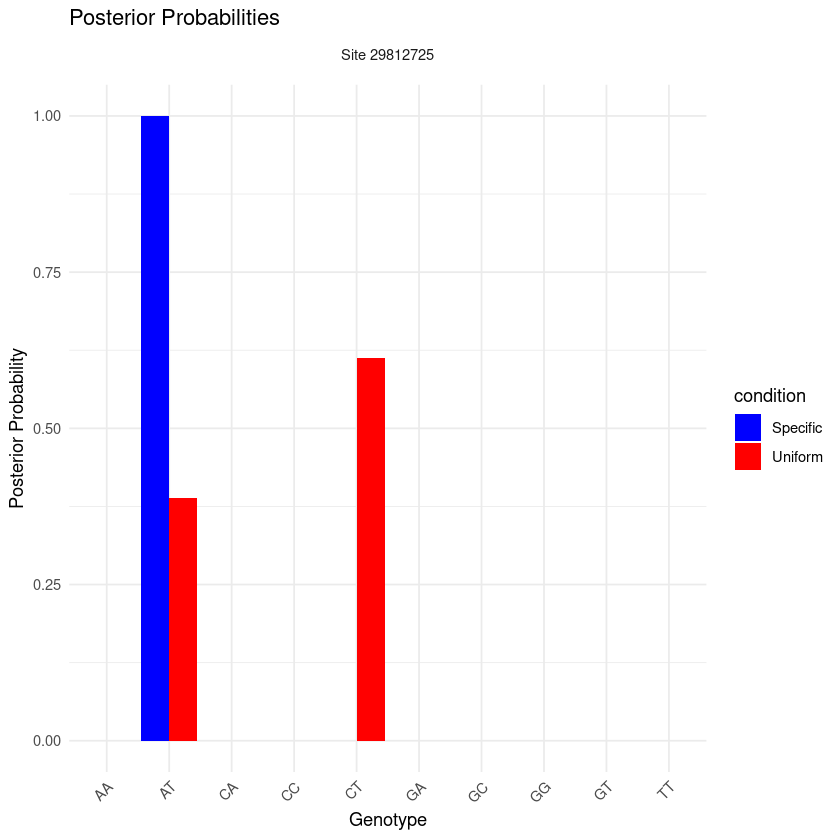

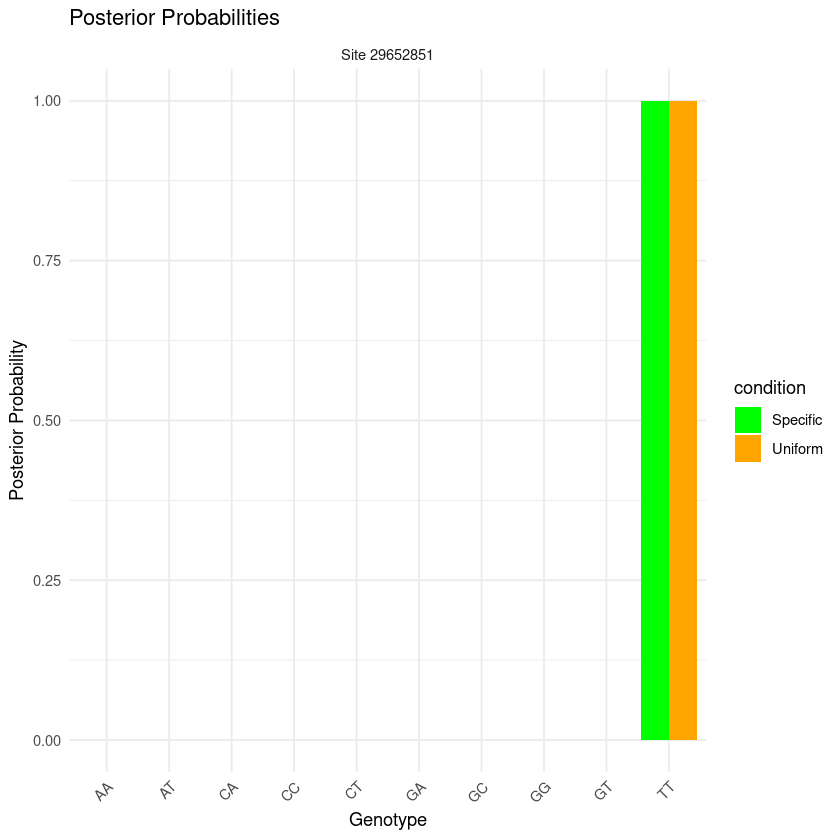

In [11]:
library(ggplot2)


# Site 1
df_uniform <- data.frame(genotype = genotypes, posterior = posterior_uniform[,1], condition = "Uniform", site = "Site 29812725
")
df_specific <- data.frame(genotype = genotypes, posterior = posterior_specific[,1], condition = "Specific", site = "Site 29812725
")

# Site 2
df_uniform_2 <- data.frame(genotype = genotypes, posterior = posterior_uniform[,2], condition = "Uniform", site = "Site 29652851")
df_specific_2 <- data.frame(genotype = genotypes, posterior = posterior_specific[,2], condition = "Specific", site = "Site 29652851")


combined_df <- rbind(df_uniform, df_specific)
combined_df_2 <- rbind(df_uniform_2, df_specific_2)

# site 1
ggplot(combined_df, aes(x = genotype, y = posterior, fill = condition)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  facet_wrap(~ site) +
  labs(x = "Genotype", y = "Posterior Probability", title = "Posterior Probabilities") +
  scale_fill_manual(values = c("blue", "red")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# site 2
ggplot(combined_df_2, aes(x = genotype, y = posterior, fill = condition)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  facet_wrap(~ site) +
  labs(x = "Genotype", y = "Posterior Probability", title = "Posterior Probabilities") +
  scale_fill_manual(values = c("green", "orange")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))




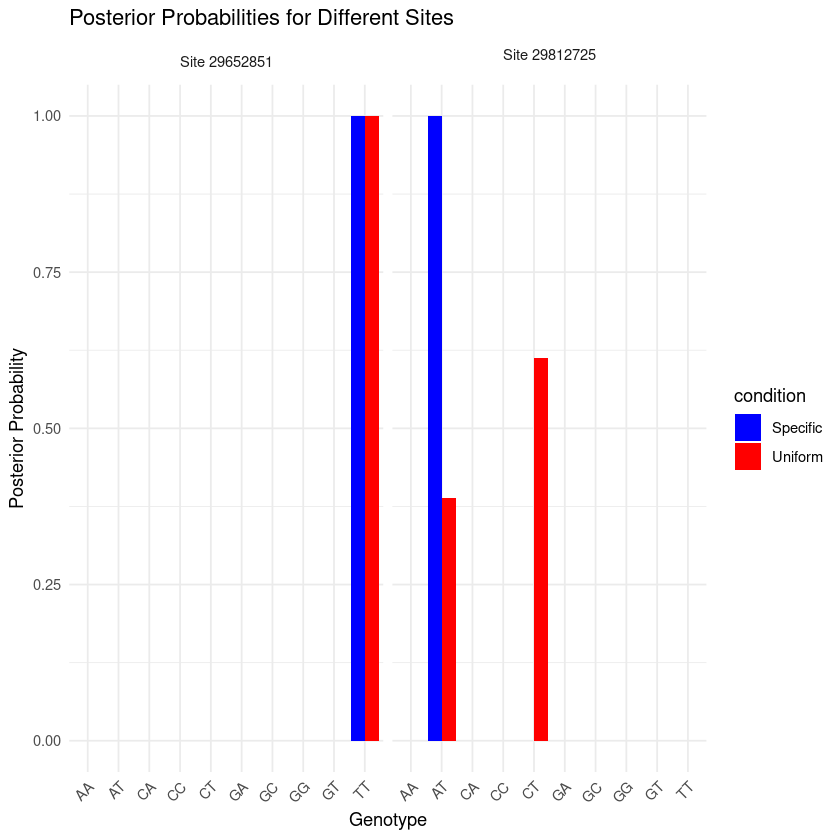

In [12]:
combined_df <- rbind(df_uniform, df_specific, df_uniform_2, df_specific_2)

ggplot(combined_df, aes(x = genotype, y = posterior, fill = condition)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  facet_wrap(~ site, ncol = 2) + 
  scale_fill_manual(values = c("blue", "red", "green", "orange")) +
  labs(x = "Genotype", y = "Posterior Probability", title = "Posterior Probabilities for Different Sites") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
